In [1]:
%matplotlib inline

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
plt.ion()

In [3]:
from PIL import Image

In [4]:
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
#         transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [5]:
# Data augmentation and normalization for training

data_dir = '/home/gamerx/Downloads/dogs-vs-cats/final_dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=16)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
len(class_names)

2

In [7]:
len(image_datasets['val']) +len(image_datasets['train'])

25000

In [8]:
len(image_datasets['train'])

22500

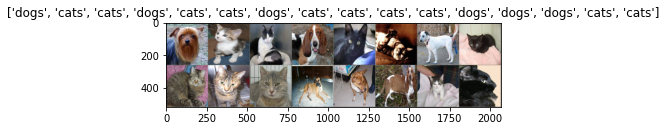

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        #print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, [train_loss, train_acc, val_loss, val_acc]

In [11]:
def visualize_model(model, num_images=2):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
model_ft = models.densenet121(pretrained=True)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()


In [20]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [13]:
model_ft, info = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=34)


Epoch 0/33
----------


/home/gamerx/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.6869 Acc: 0.5792
val Loss: 0.6843 Acc: 0.5780
Epoch 1/33
----------
train Loss: 0.6378 Acc: 0.6285
val Loss: 0.6256 Acc: 0.6572
Epoch 2/33
----------
train Loss: 0.5650 Acc: 0.7093
val Loss: 0.5552 Acc: 0.7092
Epoch 3/33
----------
train Loss: 0.4553 Acc: 0.7836
val Loss: 0.3714 Acc: 0.8304
Epoch 4/33
----------
train Loss: 0.3135 Acc: 0.8655
val Loss: 0.2472 Acc: 0.8968
Epoch 5/33
----------
train Loss: 0.2594 Acc: 0.8916
val Loss: 0.2173 Acc: 0.9060
Epoch 6/33
----------
train Loss: 0.2333 Acc: 0.9026
val Loss: 0.2182 Acc: 0.8968
Epoch 7/33
----------
train Loss: 0.2044 Acc: 0.9158
val Loss: 0.1846 Acc: 0.9252
Epoch 8/33
----------
train Loss: 0.1860 Acc: 0.9254
val Loss: 0.1598 Acc: 0.9308
Epoch 9/33
----------
train Loss: 0.1550 Acc: 0.9379
val Loss: 0.1393 Acc: 0.9444
Epoch 10/33
----------
train Loss: 0.1493 Acc: 0.9393
val Loss: 0.1408 Acc: 0.9416
Epoch 11/33
----------
train Loss: 0.1421 Acc: 0.9420
val Loss: 0.1414 Acc: 0.9396
Epoch 12/33
----------
train Loss: 0

In [21]:
model_ft, info = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)


Epoch 0/9
----------
train Loss: 0.0681 Acc: 0.9743
val Loss: 0.0913 Acc: 0.9648
Epoch 1/9
----------
train Loss: 0.0674 Acc: 0.9735
val Loss: 0.0902 Acc: 0.9664
Epoch 2/9
----------
train Loss: 0.0652 Acc: 0.9744
val Loss: 0.0951 Acc: 0.9648
Epoch 3/9
----------
train Loss: 0.0637 Acc: 0.9752
val Loss: 0.0944 Acc: 0.9632
Epoch 4/9
----------
train Loss: 0.0622 Acc: 0.9765
val Loss: 0.0909 Acc: 0.9676
Epoch 5/9
----------
train Loss: 0.0610 Acc: 0.9781
val Loss: 0.0897 Acc: 0.9656
Epoch 6/9
----------
train Loss: 0.0609 Acc: 0.9776
val Loss: 0.0917 Acc: 0.9644
Epoch 7/9
----------
train Loss: 0.0608 Acc: 0.9760
val Loss: 0.0901 Acc: 0.9660
Epoch 8/9
----------
train Loss: 0.0619 Acc: 0.9769
val Loss: 0.0904 Acc: 0.9672
Epoch 9/9
----------
train Loss: 0.0607 Acc: 0.9775
val Loss: 0.0934 Acc: 0.9644
Training complete in 120m 35s
Best val Acc: 0.967600


In [ ]:
torch.save(model_ft.state_dict(), 'DenseNet1.pth')

In [ ]:
torch.load(model_ft.state_dict(), 'CD_densenet121_no_aug.pth')

In [ ]:
show_info(info, 'resnet50', 0)

## NOW PREDICTING ON THE VALIDATION SET

In [22]:
#now only using code for pridiction 
class ppDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_dir, return_labels=False, transforms=None):
        self.df = df
        self.image_dir = image_dir
        self.transforms = transforms
        self.return_labels = return_labels
        self.label_map = {'healthy':0, 'multiple_diseases':1, 'rust':2, 'scab':3}
        self.label_map_reverse = {v:k for k,v in self.label_map.items()}
        
    def __len__(self):
        return self.df.__len__()
    
    def __getitem__(self, idx):
        image_path = self.image_dir + str(self.df.loc[idx, 'id']) + '.jpg'
        image = Image.open(image_path).convert('RGB')
        
        if self.transforms:
            image = self.transforms(image)

        if self.return_labels:
            # label = torch.tensor(self.df.loc[idx, ['healthy', 'multiple_diseases', 'rust', 'scab']]).unsqueeze(1)
            label = torch.tensor(self.df.loc[idx, ['healthy', 'multiple_diseases', 'rust', 'scab']]).unsqueeze(-1)
            return image, label, self.label_map_reverse[label.squeeze(1).numpy().argmax()]
        else:
            return image

In [23]:
test_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        #transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [24]:
import pandas as pd
te_df = pd.read_csv('/home/gamerx/Downloads/dogs-vs-cats/sampleSubmission.csv')

In [25]:
te_df

,id,label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
12495,12496,0
12496,12497,0
12497,12498,0
12498,12499,0


In [26]:
te_dataset = ppDataset(te_df, '/home/gamerx/Downloads/dogs-vs-cats/test1/', return_labels = False, transforms = test_transforms['train'])


In [27]:
len(te_dataset)

12500

In [28]:
dataloaders_test = torch.utils.data.DataLoader(te_dataset, batch_size=32,shuffle=False, num_workers=16)

In [29]:
len(dataloaders_test)

391

In [30]:
image=next(iter(dataloaders_test))

In [31]:
# x=0
# for image in dataloaders_test:
#     if x==0:
#         y=torch.squeeze(image[1])
#         plt.imshow(np.transpose(y,(1,2,0)))
#         break
#     x=x+1

In [32]:
def get_all_predictions(loaded_data,my_network):
#   my_network 
  final_stacked_result=None
  for batch in (loaded_data):
    with torch.set_grad_enabled(False):
         predictions=my_network(batch.to(device))
         test_prediction=predictions.data.cpu()
         if final_stacked_result is None:
            final_stacked_result=test_prediction.data.cpu()
         else:
             final_stacked_result=torch.cat((final_stacked_result,test_prediction.data.cpu()),dim=0)
  return final_stacked_result

#calling the function 
my_predictions=get_all_predictions(dataloaders_test,model_ft)

In [33]:
my_predictions.shape

torch.Size([12500, 2])

In [34]:
y=my_predictions.argmax(dim=1)

In [35]:
y.shape

torch.Size([12500])

In [36]:
#now just save the results in the csv file
final_csv_with_labels_uploaded=te_df
final_csv_with_labels_uploaded['label']=y

In [37]:
final_csv_with_labels_uploaded

,id,label
0,1,1
1,2,1
2,3,1
3,4,1
4,5,0
...,...,...
12495,12496,0
12496,12497,0
12497,12498,1
12498,12499,1


In [39]:
final_csv_with_labels_uploaded.to_csv('predicted_test_csv_DenseNet256.csv',index=False)

In [1]:
[1,2,3] + [4,5,6]

[1, 2, 3, 4, 5, 6]

In [2]:
["hi"] * 4

['hi', 'hi', 'hi', 'hi']

In [3]:
x="dog"

In [7]:
x[2]='1'

TypeError: 'str' object does not support item assignment

In [8]:
size([1,2,3])

NameError: name 'size' is not defined

In [11]:
ord('4')

52

In [38]:
sentence="htiW yreve llac i egnahc dna reven llits sselnu ti si owt dnasuoht dna .net sA morf taht dees I egreme dna retfa ti I llahs reven .egnahc m'I elohw dna ,larutan erom naht eno tub ssel naht a .dnasuoht m'I eht tsrif uoy lliw teg dna eht eno uoy lliw timbus"

In [39]:
sentence

"htiW yreve llac i egnahc dna reven llits sselnu ti si owt dnasuoht dna .net sA morf taht dees I egreme dna retfa ti I llahs reven .egnahc m'I elohw dna ,larutan erom naht eno tub ssel naht a .dnasuoht m'I eht tsrif uoy lliw teg dna eht eno uoy lliw timbus"

In [46]:
sentence='I ma tahW .mynorca na tsuj ma I dna elddim eht fo lla yawa ekat ;drow a llits ma I ,ertnec eht fo eceip a tuohtiW .netae eb llits nac I dna dne eht yawa ekat ;netsil llits nac uoy dna daeh ym evomeR .tiurf tnereffid a emoceb nac I dna egatnom a ot em ddA .emirc a eb dluoc ti ,srettel ym egnarraer uoy fI .emas eht tsuj dnuos dluow I ,em fo owt dah uoy fI .epahs a osla tub ,tiurf a ma I'

In [47]:
all_splits=sentence.split()

In [48]:
all_splits

['I',
 'ma',
 'tahW',
 '.mynorca',
 'na',
 'tsuj',
 'ma',
 'I',
 'dna',
 'elddim',
 'eht',
 'fo',
 'lla',
 'yawa',
 'ekat',
 ';drow',
 'a',
 'llits',
 'ma',
 'I',
 ',ertnec',
 'eht',
 'fo',
 'eceip',
 'a',
 'tuohtiW',
 '.netae',
 'eb',
 'llits',
 'nac',
 'I',
 'dna',
 'dne',
 'eht',
 'yawa',
 'ekat',
 ';netsil',
 'llits',
 'nac',
 'uoy',
 'dna',
 'daeh',
 'ym',
 'evomeR',
 '.tiurf',
 'tnereffid',
 'a',
 'emoceb',
 'nac',
 'I',
 'dna',
 'egatnom',
 'a',
 'ot',
 'em',
 'ddA',
 '.emirc',
 'a',
 'eb',
 'dluoc',
 'ti',
 ',srettel',
 'ym',
 'egnarraer',
 'uoy',
 'fI',
 '.emas',
 'eht',
 'tsuj',
 'dnuos',
 'dluow',
 'I',
 ',em',
 'fo',
 'owt',
 'dah',
 'uoy',
 'fI',
 '.epahs',
 'a',
 'osla',
 'tub',
 ',tiurf',
 'a',
 'ma',
 'I']

In [49]:
new_string=""

In [50]:
for single_word in all_splits:
    reversed_word=single_word[len(single_word)::-1]
    new_string=new_string+reversed_word+" "
    

In [51]:
new_string

'I am What acronym. an just am I and middle the of all away take word; a still am I centre, the of piece a Without eaten. be still can I and end the away take listen; still can you and head my Remove fruit. different a become can I and montage a to me Add crime. a be could it letters, my rearrange you If same. the just sound would I me, of two had you If shape. a also but fruit, a am I '

SyntaxError: invalid syntax (<ipython-input-52-eb4d75c78efb>, line 1)

In [53]:
import random

In [56]:
import random

random.seed(2010)
print(random.randint(1,1000))

143
